In [1]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Downloading the dataset

The kaggle challange can be [accessed  here](https://www.kaggle.com/competitions/isic-2024-challenge/overview). \
The dataset is a set of RGB images with varying dimentions. The images are labeled whether they depict skin cancer. Additional metadata is also provided (e.g. age, sex, etc. of the patient)


Run the cell below to install the kaggle library. The `dowload_data()` function uses this library to download the dataset. For this, you have to configure your username and api-key in a json format under the `~/.kaggle` directory.
Additionally you can download the dataset using the kaggle cli:
```
kaggle competitions download -c isic-2024-challenge
```
or directly from the website.

In [ ]:
# Run to install kaggle package. Place the username and api key in a json configuration under ~/.kaggle directory.
!python -m pip install kaggle --upgrade

In [ ]:
import kaggle
import zipfile

def download_data():
    challange_name = "isic-2024-challenge"
    # create directory for the data
    Path.mkdir("data", exist_ok=True)
    kaggle.api.competition_download_files(challange_name)

    # extract zip to the data dir
    with zipfile.ZipFile(challange_name + ".zip") as zip_handle:
        zip_handle.extractall("data")

In [ ]:
download_data()

## Loading the data

Loading the images, corresponding metadata and obtaining the labels

In [2]:
DATASET_HOME = Path.cwd() / "data"
TRAIN_IMAGES_PATH = DATASET_HOME / "train-image" / "image"
METADATA_PATH = DATASET_HOME / "train-metadata.csv"

image_iterator = TRAIN_IMAGES_PATH.glob("*")
image_count = len(list(image_iterator))
print("The dataset contains {} images".format(image_count))

The dataset contains 401059 images


In [3]:
# Read the metadata, which contains the labels

df = pd.read_csv(METADATA_PATH)
df.head()

C:\Users\csonto.benjamin\AppData\Local\Temp\ipykernel_25424\1625701450.py:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(METADATA_PATH)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [4]:
from itertools import islice

# Uncomment the multiplication to only load a small portion of the dataset for experimentation
load_count = int(image_count * 0.001)
print("Number of images to be loaded {}".format(load_count))

X = []
metadata = []
for file_path in islice(TRAIN_IMAGES_PATH.glob("*"), 0, load_count):
    filename = file_path.with_suffix("").name
    row = df.loc[df["isic_id"] == filename]
    metadata.append(row)
    with Image.open(file_path) as im:
        X.append(Image.open(file_path))

Y = [row["target"] for row in metadata]

Number of images to be loaded 401


### Show example of a negative and a positive sample

Text(0.5, 1.0, 'Benign')

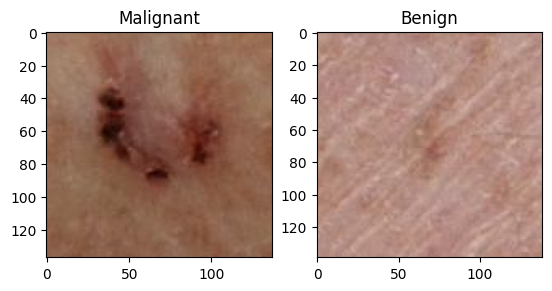

In [5]:
malignant_idx = next(i for i,v in enumerate(Y) if v.item() == 1)
malignant = X[malignant_idx]
benign_idx = next(i for i,v in enumerate(Y) if v.item() == 0)
benign = X[benign_idx]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(malignant)
ax[0].set_title("Malignant")

ax[1].imshow(benign)
ax[1].set_title("Benign")

## Preprocessing

* Scaling the images
* Creating the train-test splits

Not all images are of the same dimentionality. The most straight-forward solution is to rescale the images to match the most frequent dimentions. \
This solution shouldn't significantly worsen the performance of the models as long as all the images are n by n sized

In [6]:
sizes = [im.size for im in X]
not_square = list(filter(lambda s: s[0] != s[1] ,sizes))
print(f"{len(not_square)} images are not n by n.")

values, counts = np.unique(sizes, return_counts=True)
most_frequent = values[np.argmax(counts)]
print(f"Most frequent size: {most_frequent}")

[] images are not n by n.
Most frequent size: 139


In [7]:
scaled_images = [im.resize([most_frequent, most_frequent]) for im in X]
# Maping to a np array and scaling the images to the [0,1] interval
X_scaled = np.array(scaled_images) / 255
X_scaled.shape

(401, 139, 139, 3)

In [10]:
from sklearn.model_selection import train_test_split

test_size=0.3

# Validation split to be handled by the model
X_train, X_test, meta_train, meta_test, Y_train, Y_test = train_test_split(X_scaled, metadata, Y, test_size=test_size)
print(f"Training dataset: {X_train.shape[0]}\nTest dataset: {X_test.shape[0]}")

Training dataset: 280
Test dataset: 121


     age_approx   sex
147        65.0  male
Benign


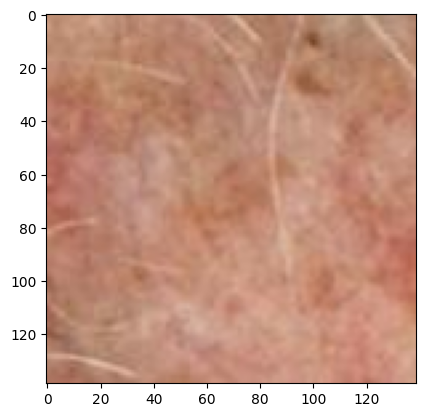

In [19]:
# Inspect a random training instance

random_idx = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[random_idx])
print(meta_train[random_idx][["age_approx", "sex"]])  # TODO: Find other useful columns
print("Malignant" if Y[random_idx].item() else "Benign")